In [1]:
import scipy.io as si
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('../src/')
import opencourse.konrad_funcs as kf
%matplotlib inline

Modeling data involves using observed datapoints to try to make a more general description of patterns that we see. It can be useful to describe the trajectory of a neuron's behavior in time, or to describe the relationship between two variables. Here we will cover the basics of modeling, as well as how we can investigate variability in data and how it affects modeling results.

In [3]:
# Load data and pull out important values
data = si.loadmat('../../data/StevensonV2.mat')

handVel = data['handVel']
handPos = data['handPos']
spikes = data['spikes']
time = data['time']

In [4]:
# Remove all times where speeds are very slow
threshold = .015
isGood = np.where((handVel[0, :]**2 + handVel[1, :]**2) > threshold)[0]
handVel = handVel[:2,][:, isGood]
handPos = handPos[:2][:, isGood]
spikes = spikes[:, isGood]
time = time.squeeze()[isGood]
angle = np.arctan2(handVel[0, :], handVel[1, :])

# Part 1
Plot the spike counts as a function of angle. A small amount of meaningless vertical noise has been added to make visualation easier.

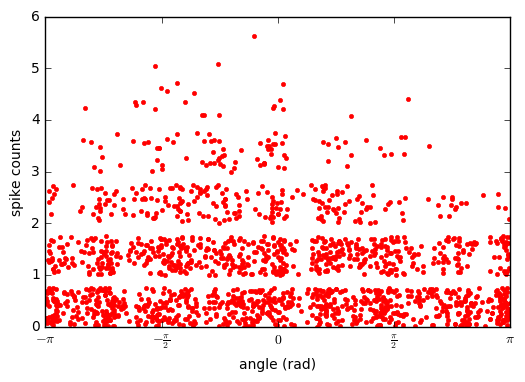

In [5]:
# Plot Raw Data
nNeuron = 0
fig, ax = plt.subplots()
spikes_noisy = spikes[nNeuron] + 0.75 * np.random.rand(spikes[nNeuron].shape[0])
max_s = spikes[nNeuron].max()+1
ax.plot(angle, spikes_noisy, 'r.')
kf.format_plot(ax, max_s)

We'll also plot the mean spiking activity over time below. Calculating the mean across time is already a kind of model. It makes the assumption that the mean is a "good" description of spiking activity at any given time point.

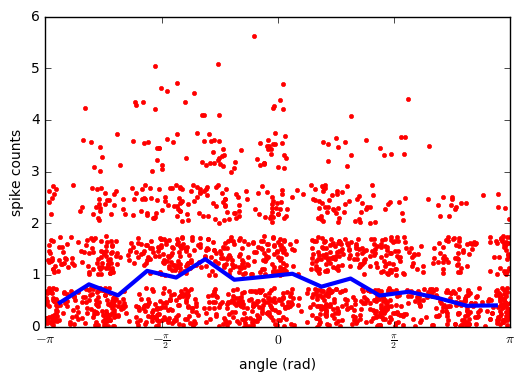

In [6]:
# Make a simple tuning curve
angles = np.arange(-np.pi, np.pi, np.pi / 8.)
nSpikes = np.zeros(len(angles))
angle_bins = np.digitize(angle, angles)
for ii in range(len(angles)):
    mask_angle = angle_bins == (ii + 1)
    nSpikes[ii] = np.mean(spikes[nNeuron, mask_angle])

fig, ax = plt.subplots()
ax.plot(angle, spikes_noisy, 'r.')
ax.plot(angles + np.pi / 16., nSpikes, lw=3)
kf.format_plot(ax, max_s)

## Bootstrap error bars
The mean is useful, but it also removes a lot of information about the data. In particular, it doesn't tell us anything about how variable the data is. For this, we should calculate error bars.

Thought there are many ways to calculate error bars analytically (ie, with mathematical equations), it is recommended to use bootstrapping if possible. This is a method for computationally calculating error bars in order to avoid making as many assumptions about your data. We'll perform this below.

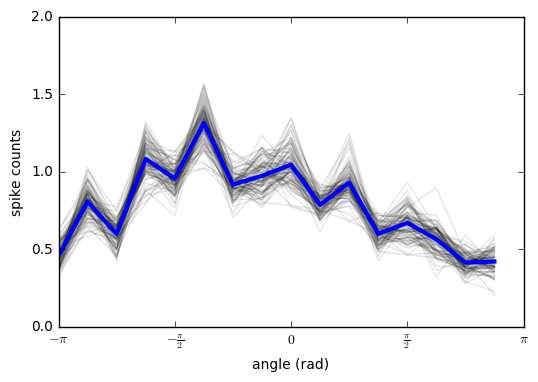

In [7]:
n_angle_samples = angle.size
n_angles = angles.size
n_boots = 100
simulations = np.zeros([n_boots, n_angles])

for ii in range(n_boots):
    # Take a random sample of angle values
    ixs = np.random.randint(0, n_angle_samples, n_angle_samples)
    angle_sample = angle[ixs]
    spike_sample = spikes[:, ixs]
    # Group these samples by bins of angle
    angle_bins = np.digitize(angle_sample, angles)
    
    # For each angle, calculate the datapoints corresponding to that angle
    # Take the mean spikes for each bin of angles
    for jj in range(n_angles):
        mask_angle = angle_bins == (jj + 1)
        this_spikes = spike_sample[nNeuron, mask_angle]
        simulations[ii, jj] = np.mean(this_spikes)

fig, ax = plt.subplots()
_ = ax.plot(angles[:, np.newaxis], simulations.T, color='k', alpha=.1)
_ = ax.plot(angles, simulations.mean(0), color='b', lw=3)
kf.format_plot(ax, np.ceil(simulations.max()))

As you can see, there is some variability in the calculated mean across bootstrap samples. We can incorporate this variability into our original mean plot by including error bars. We calculate these by taking the 2.5th and 97.5th percentiles of the mean at each timepoint across all of our bootstraps. This is called building a 95% confidence interval.

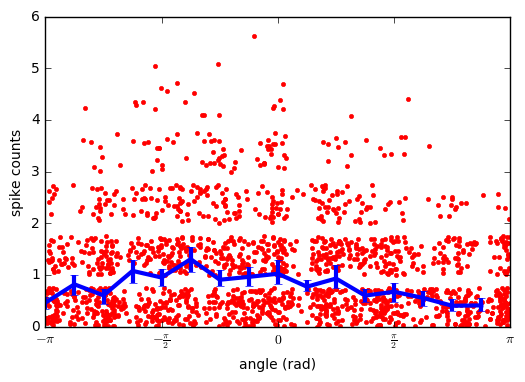

In [8]:
# Plot data + error bars
clo, chi = np.percentile(simulations, [2.5, 97.5], axis=0)

fig, ax = plt.subplots()
ax.plot(angle, spikes_noisy, 'r.', zorder=-1)
ax.errorbar(angles, nSpikes, yerr=[nSpikes-clo, chi-nSpikes], lw=3)
kf.format_plot(ax, max_s)

### Advanced exercise
Do this for all neurons. Do they actually have cosine tuning as indicated by the research?

# Part 2
We can also fit a parameterized model to the spike count. In this case we'll use a Poisson distribution where the rate parameters depends on the cosine of the angle away from the arm and a scaling parameters.
$$P(n, \theta) = \frac{\lambda(\theta)^n\exp(-\lambda(\theta))}{n!}$$
where
$$\lambda = \alpha+\beta\cos(\theta-\theta_\text{arm})$$

In [10]:
# This package allows us to perform optimizations
from scipy import optimize as opt

We'll use the `fmin` function in python, which allows us to define an arbitrary "cost" function, that is then minimized by tuning model parameters.

In [11]:
initial_guess=  [.8, 0.1, 4]
params = opt.fmin(kf.evaluateScoreCosExp, initial_guess,
                  args=(spikes[nNeuron, :], angle))

Optimization terminated successfully.
         Current function value: 1965.435590
         Iterations: 89
         Function evaluations: 160


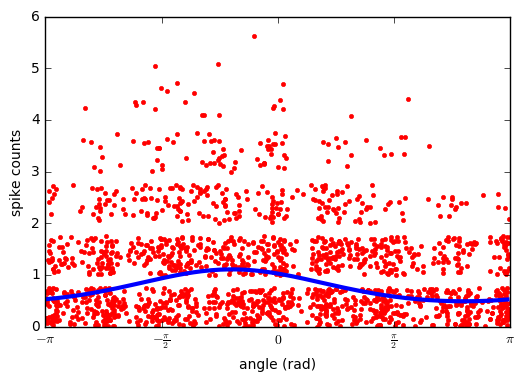

In [12]:
plt_angle = np.arange(-np.pi, np.pi, np.pi / 80.)
out = np.exp(params[0] + params[1] * np.cos(plt_angle - params[2]))
fig, ax = plt.subplots()
ax.plot(angle, spikes_noisy, 'r.')
ax.plot(plt_angle, out, lw=3)
kf.format_plot(ax, max_s)

By optimizing this cost function, the model has uncovered the above structure (blue line) in the data. Does it seem to describe the data well? Try using more complicated model functions and see how it affects the result.

### Advanced exercise
Is exponential better than linear-threshold?

# Part 3

We can also use more powerful machine learning tools to regress onto the spike count.

We'll use Random Forests and Regression models to predict spike count as a function of arm position and velocity. For each of these models we can either regress onto the spike count treating it like a continuous value, or we can predict discreet values for spike count treating it like a classification problem.

We'll fit a number of models, then calculate their ability to predict the values of datapoints they were not trained on. This is called "cross-validating" your model, which is a crucial component of machine learning.

In [13]:
from sklearn.ensemble import RandomForestRegressor as RFR, RandomForestClassifier as RFC
from sklearn.linear_model import LinearRegression as LR, LogisticRegression as LgR

In [14]:
nNeuron = 0
# First lets have some meaningful regressors
Y = spikes[nNeuron]
X = np.vstack((handVel, handPos)).T

models = [RFR(n_estimators=10, n_jobs=-1), RFC(n_estimators=10, n_jobs=-1),
          LR(n_jobs=-1), LgR(solver='lbfgs', multi_class='multinomial')]
model_names = ['Random Forest\nRegresion', 'Random Forest\nClassification',
               'Linear Regression', 'Logistic Regression']

folds = 10
mse = np.zeros((len(models), folds))
mse_train = np.zeros((len(models), folds))

def mse_func(y, y_hat):
    return ((y-y_hat)**2).mean()

for ii in range(folds):
    indsTrain = np.arange(Y.size)
    indsTest = indsTrain[np.mod(indsTrain, folds) == ii]
    indsTrain = indsTrain[np.logical_not(np.mod(indsTrain, folds) == ii)]
    for jj, model in enumerate(models):
        model.fit(X[indsTrain], Y[indsTrain])
        mse[jj, ii] = mse_func(model.predict(X[indsTest]), Y[indsTest])
        mse_train[jj, ii] = mse_func(model.predict(X[indsTrain]), Y[indsTrain])

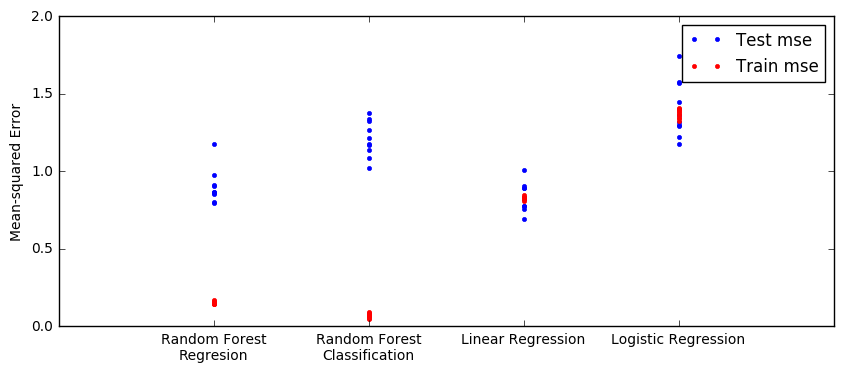

In [15]:
f, ax = plt.subplots(figsize=(10, 4))
ax.plot(range(4), mse, 'b.')
ax.plot(range(4), mse_train, 'r.')
ax.plot(-10, 10, 'b.', label='Test mse')
ax.plot(-10, 10, 'r.', label='Train mse')
plt.legend(loc='best')
ax.set_xticks(range(4))
ax.set_xticklabels(model_names)
ax.set_ylim(0, 2)
ax.set_ylabel('Mean-squared Error')
_ = ax.set_xlim(-1, 4)

### Advanced exercise
Try adding the arm speed (norm of the velocity vector) as an additional regression variable. Does this improve the model's ability to predict held-out datapoints?